# Tutorial 11: DeepWalk and node2vec - Implementation details
  

Paper:
* [DeepWalk: Online Learning of Social Representation](https://arxiv.org/pdf/1403.6652.pdf)  
* [node2vec: Scalable Feature Learning for Networks](https://arxiv.org/pdf/1607.00653.pdf)  

Code:

 * [node2vec doc](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html?highlight=node2vec#torch_geometric.nn.models.Node2Vec)
 * [node2vec code](https://pytorch-geometric.readthedocs.io/en/latest/_modules/torch_geometric/nn/models/node2vec.html)
 * [Example on clustering](https://github.com/rusty1s/pytorch_geometric/blob/master/examples/node2vec.py)

# Setup

In [5]:
import torch
import torch_cluster
from torch_geometric.nn import Node2Vec
from torch_geometric.datasets import Planetoid
from tqdm.notebook import tqdm

import ogb
# print(ogb.__version__)

import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd
import optuna
from sklearn.manifold import TSNE

import time
import json
import os.path as osp
from pprint import pprint

from graph_lib import print_graph_info
from graph_lib import pyg_graph_data_visualizer


In [6]:
dataset = 'Cora'
path = osp.join('.', 'data', dataset)
dataset = Planetoid(path, dataset)
data = dataset[0]
print(data)
#print(len(dataset))

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


In [ ]:
model = Node2Vec(data.edge_index, embedding_dim=128,
                 walk_length=20,                        # lenght of rw
                 context_size=10, walks_per_node=20,
                 num_negative_samples=1,
                 p=200, q=1,                             # bias parameters
                 sparse=True)

try:
    model.load_state_dict(torch.load('node2vec_model.pth'))
except RuntimeError as e:
    print(f"RuntimeError: {e}")
# Set the model to 
# 
# ation mode if you are not training it further
model.eval()

C:\Users\csaba\AppData\Local\Temp\ipykernel_6808\4164930637.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('node2vec_model.pth'))


Node2Vec(2708, 128)

In [8]:
print_graph_info(dataset)

Type:  <class 'torch_geometric.datasets.planetoid.Planetoid'>
Number of graphs:  1
Cora()
Keys of the data object: ['x', 'val_mask', 'test_mask', 'train_mask', 'edge_index', 'y']

Has isolated nodes: False
Has self loops: False
Is directed: False

Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Number of node features: 1433
Number of edge features: 0
Number of classes: 7


In [9]:
print_graph_info(dataset[0])

Type:  <class 'torch_geometric.data.data.Data'>
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Keys of the data object: ['x', 'val_mask', 'test_mask', 'train_mask', 'edge_index', 'y']

Has isolated nodes: False
Has self loops: False
Is directed: False

Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Number of node features: 1433
Number of edge features: 0
AttributeError: 'GlobalStorage' object has no attribute 'num_classes'


In [10]:
# pprint([x for x in dir(data) if '_' != x[0]])

# Random walks

### The data loader

In [11]:
loader = model.loader(batch_size=128, shuffle=True, num_workers=0) 
# 128*20 random walks per batch. 20 is the number of walks per node
# The number of elements in each batch isn't `batch_size * walks_per_node`. 
# The correct computation is: `(walk_length - context_size + 1) * walks_per_node * batch_size`. 
# The first term is the number of possible walks of `context_size` in `context_length`.

(20-10+1)*20*128

28160

In [12]:
for idx, (pos_rw, neg_rw) in enumerate(loader):
    print(idx, pos_rw.shape, neg_rw.shape)

# positve and negative batches, 28160 sample or context, 10 is the context size 

0 torch.Size([28160, 10]) torch.Size([28160, 10])
1 torch.Size([28160, 10]) torch.Size([28160, 10])
2 torch.Size([28160, 10]) torch.Size([28160, 10])
3 torch.Size([28160, 10]) torch.Size([28160, 10])
4 torch.Size([28160, 10]) torch.Size([28160, 10])
5 torch.Size([28160, 10]) torch.Size([28160, 10])
6 torch.Size([28160, 10]) torch.Size([28160, 10])
7 torch.Size([28160, 10]) torch.Size([28160, 10])
8 torch.Size([28160, 10]) torch.Size([28160, 10])
9 torch.Size([28160, 10]) torch.Size([28160, 10])
10 torch.Size([28160, 10]) torch.Size([28160, 10])


11 torch.Size([28160, 10]) torch.Size([28160, 10])
12 torch.Size([28160, 10]) torch.Size([28160, 10])
13 torch.Size([28160, 10]) torch.Size([28160, 10])
14 torch.Size([28160, 10]) torch.Size([28160, 10])
15 torch.Size([28160, 10]) torch.Size([28160, 10])
16 torch.Size([28160, 10]) torch.Size([28160, 10])
17 torch.Size([28160, 10]) torch.Size([28160, 10])
18 torch.Size([28160, 10]) torch.Size([28160, 10])
19 torch.Size([28160, 10]) torch.Size([28160, 10])
20 torch.Size([28160, 10]) torch.Size([28160, 10])
21 torch.Size([4400, 10]) torch.Size([4400, 10])


In [13]:
idx, (pos_rw, neg_rw) = next(enumerate(loader))

In [14]:
idx

0

In [15]:
(pos_rw.shape, neg_rw.shape)

(torch.Size([28160, 10]), torch.Size([28160, 10]))

In [16]:
pos_rw # one context is starting from 1826 node then 448 etc, its 10 long

tensor([[2523,  867, 2442,  ..., 1715, 1154, 2514],
        [2651,  105, 2476,  ..., 1209,   64, 2616],
        [2189,   69, 1926,  ..., 2052, 1926, 1920],
        ...,
        [ 462, 1048,  462,  ..., 1048,  462, 1048],
        [1652,  498,  323,  ...,   88, 1288, 1309],
        [ 490, 1309, 1288,  ...,  279,  242,  838]])

In [17]:
neg_rw

tensor([[2523, 2017, 1069,  ...,  515, 2115,  167],
        [2651, 2202, 1280,  ...,  960, 1590,  398],
        [2189,  164,  128,  ...,  437, 1733, 1854],
        ...,
        [1211, 1877, 1382,  ...,  273, 2346,  468],
        [2370, 1903, 1821,  ..., 1039,  908,  336],
        [ 536,  880, 2657,  ..., 1027,  644, 2152]])

### Visualization

In [18]:
import networkx as nx
edge_tuples = [tuple(x) for x in data.edge_index.numpy().transpose()]
G = nx.from_edgelist(edge_tuples)
pos = nx.spring_layout(G, center=[0.5, 0.5])
nx.set_node_attributes(G, pos, 'pos')

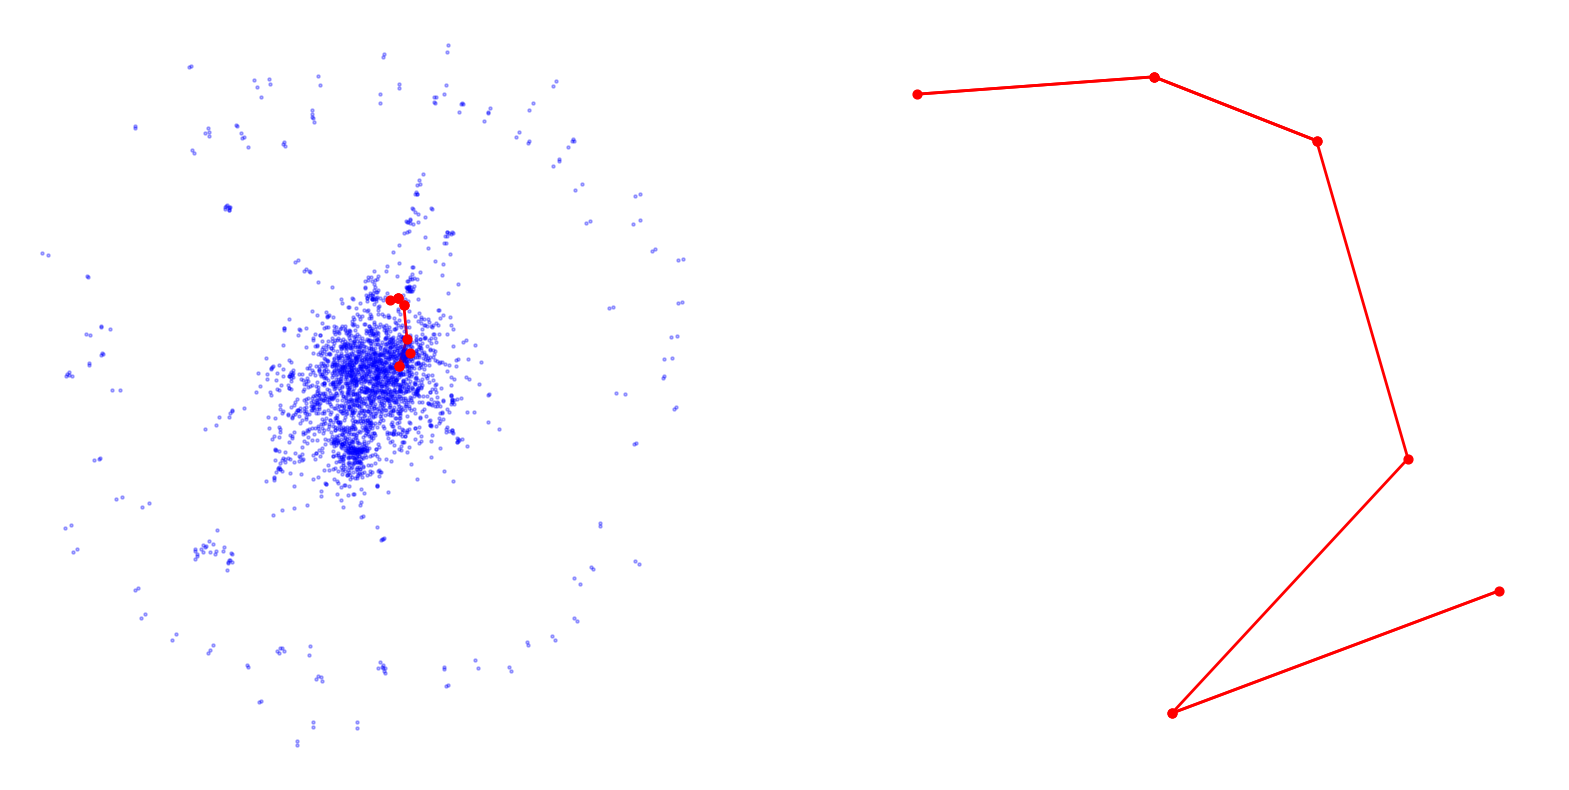

In [19]:
nodelist = next(enumerate(loader))[1][0][0].tolist()
walk = nx.path_graph(len(nodelist)) # one positive context
# walk = nx.relabel_nodes(walk, {idx: node_id for idx, node_id in enumerate(nodelist)})
nx.set_node_attributes(walk, {idx: pos[node_id] for idx, node_id in enumerate(nodelist)}, 'pos')

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 2, 1)
nx.draw_networkx_nodes(G,
                       ax=ax,
                       pos=nx.get_node_attributes(G, 'pos'),
                       node_size=5,
                       alpha=0.3,
                       node_color='b')
nx.draw(walk,
        node_size=40,
        node_color='r',
        ax=ax,
        pos=nx.get_node_attributes(walk, 'pos'),
        width=2,
        edge_color='r')
ax = fig.add_subplot(1, 2, 2)
nx.draw(walk,
        node_size=40,
        node_color='r',
        ax=ax,
        pos=nx.get_node_attributes(walk, 'pos'),
        width=2,
        edge_color='r')

# Training

### Model definition

In [20]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = Node2Vec(data.edge_index, embedding_dim=128, walk_length=20,
                 context_size=10, walks_per_node=20,
                 num_negative_samples=1, p=1, q=1, sparse=True).to(device)

# return parameter p
# in-out parameter q

loader = model.loader(batch_size=128, shuffle=True, num_workers=0) 
# num_workers=0 is necessary for Windows
optimizer = torch.optim.SparseAdam(list(model.parameters()), lr=0.01)

### Training function

In [21]:
def train():
    model.train()
    total_loss = 0
    for pos_rw, neg_rw in tqdm(loader): 
        optimizer.zero_grad()
        loss = model.loss(pos_rw.to(device), neg_rw.to(device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

### Test function

In [22]:
data

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [23]:
data.y

tensor([3, 4, 4,  ..., 3, 3, 3])

In [24]:
data.y.unique()

tensor([0, 1, 2, 3, 4, 5, 6])

In [25]:
@torch.no_grad()
def test():
    model.eval()
    z = model()
    acc = model.test(z[data.train_mask], data.y[data.train_mask],
                     z[data.test_mask], data.y[data.test_mask],
                     max_iter=150)
    return acc

### Training

In [26]:
print(data)

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


In [27]:
start_time = time.time()
# for epoch in range(1, 201):
for epoch in range(1, 12):
    epoch_start_time = time.time()
    loss = train()
    acc = test()
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Acc: {acc:.4f}')
    epoch_duration = time.time() - epoch_start_time
    print(f'Last epoch duration: {epoch_duration:.2f} seconds')

elapsed_time = time.time() - start_time
print(f'Total elapsed time: {elapsed_time:.2f} seconds')
torch.save(model.state_dict(), 'node2vec_model.pth')


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 01, Loss: 7.9477, Acc: 0.1680
Last epoch duration: 30.52 seconds


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 02, Loss: 5.7682, Acc: 0.1980
Last epoch duration: 28.13 seconds


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 03, Loss: 4.5817, Acc: 0.2300
Last epoch duration: 27.03 seconds


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 04, Loss: 3.7111, Acc: 0.2840
Last epoch duration: 28.88 seconds


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 05, Loss: 3.0498, Acc: 0.3230
Last epoch duration: 27.41 seconds


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 06, Loss: 2.5437, Acc: 0.3630
Last epoch duration: 27.19 seconds


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 07, Loss: 2.1607, Acc: 0.3930
Last epoch duration: 27.45 seconds


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 08, Loss: 1.8675, Acc: 0.4120
Last epoch duration: 28.32 seconds


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 09, Loss: 1.6419, Acc: 0.4450
Last epoch duration: 31.85 seconds


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 10, Loss: 1.4634, Acc: 0.4680
Last epoch duration: 27.59 seconds


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 11, Loss: 1.3307, Acc: 0.4920
Last epoch duration: 31.86 seconds
Total elapsed time: 316.22 seconds


### Visualization

In [28]:
data.num_nodes

2708

In [29]:
zz = model(torch.arange(data.num_nodes, device=device))
print(zz.shape)
print(zz)
# 2708 row, each repreeents a node

torch.Size([2708, 128])
tensor([[ 0.1079,  0.0051, -0.3647,  ...,  0.0079,  1.0947,  0.0361],
        [-0.2762, -0.4700, -0.5532,  ..., -0.1260,  0.1385, -0.4079],
        [-0.0446, -0.1699, -0.1069,  ..., -0.3566,  0.1637, -0.0558],
        ...,
        [-0.0875,  0.3734,  0.1736,  ..., -0.0066,  0.0697, -0.0756],
        [-0.3322, -0.3482, -0.4251,  ..., -0.8122,  0.3379, -0.8075],
        [-0.2102, -0.0562, -0.8340,  ..., -0.3152,  0.4659, -0.5447]],
       grad_fn=<IndexBackward0>)


In [30]:
zzz = TSNE(n_components=2).fit_transform(zz.cpu().numpy())
zzz

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

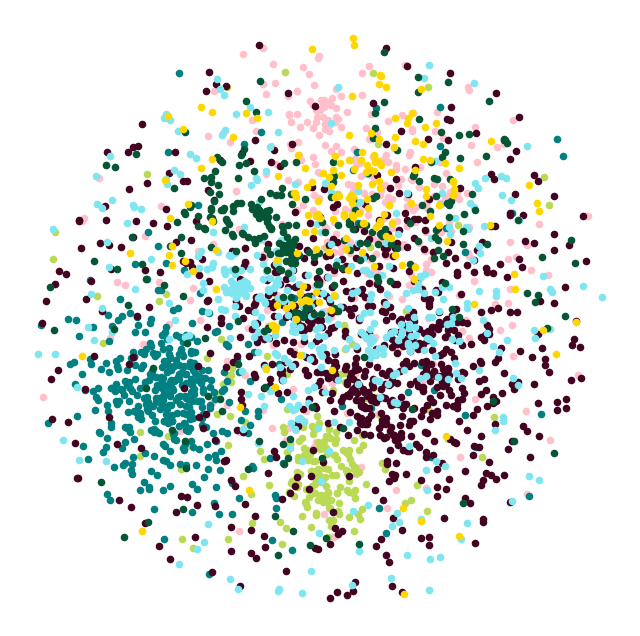

In [32]:
# is this the result of the trained model or the actual dataset? is there any reason to plot the result of the trained model? TODO
@torch.no_grad()
def plot_points(model, colors):
    model.eval() # nograd bc of this? TODO
    z = model(torch.arange(data.num_nodes, device=device))
    z = TSNE(n_components=2).fit_transform(z.cpu().numpy())
    y = data.y.cpu().numpy()

    plt.figure(figsize=(8, 8))
    for i in range(dataset.num_classes):
        plt.scatter(z[y == i, 0], z[y == i, 1], s=20, color=colors[i])
    plt.axis('off')
    plt.show()

colors = [
    '#ffc0cb', '#bada55', '#008080', '#420420', '#7fe5f0', '#065535',
    '#ffd700'
]
plot_points(model,colors)

In [ ]:
@torch.no_grad()
def plot_interactive_tsne(model):
    model.eval()
    z = model(torch.arange(data.num_nodes, device=device)).cpu().numpy()
    z_tsne = TSNE(n_components=2).fit_transform(z)
    y = data.y.cpu().numpy()

    df = pd.DataFrame({'x': z_tsne[:, 0], 'y': z_tsne[:, 1], 'label': y})
    fig = px.scatter(df, x='x', y='y', color=df['label'].astype(str),
                     title="Interactive t-SNE of Node Embeddings")
    fig.show()

plot_interactive_tsne(model_from_file)


: 

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

def objective(trial):
    # Suggest hyperparameters
    embedding_dim = trial.suggest_int('embedding_dim', 128, 128, step=64)
    walk_length = trial.suggest_int('walk_length', 30, 30, step=10)
    context_size = trial.suggest_int('context_size', 10, 20, step=5)
    walks_per_node = trial.suggest_int('walks_per_node', 10, 10, step=10)
    num_negative_samples = trial.suggest_int('num_negative_samples', 1, 10, step=2)
    p = trial.suggest_int('p', 10, 100, step=20)
    q = trial.suggest_int('q', 10, 100, step=20)
    lr = trial.suggest_int('lr', 1.0, 1.0)

    # Initialize model
    model = Node2Vec(data.edge_index, embedding_dim=embedding_dim, walk_length=walk_length,
                     context_size=context_size, walks_per_node=walks_per_node,
                     num_negative_samples=num_negative_samples, p=p, q=q, sparse=True).to(device)

    loader = model.loader(batch_size=128, shuffle=True, num_workers=0)
    optimizer = torch.optim.SparseAdam(list(model.parameters()), lr=lr)

    # Training function
    def train():
        model.train()
        total_loss = 0
        for pos_rw, neg_rw in loader:
            optimizer.zero_grad()
            loss = model.loss(pos_rw.to(device), neg_rw.to(device))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        return total_loss / len(loader)

    # Test function
    @torch.no_grad()
    def test():
        model.eval()
        z = model()
        acc = model.test(z[data.train_mask], data.y[data.train_mask],
                         z[data.test_mask], data.y[data.test_mask],
                         max_iter=150)
        return acc

    # Training loop
    for epoch in range(1, 12):
        train()
        acc = test()
        trial.report(acc, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return acc

# Create study and optimize
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

print("Best hyperparameters: ", study.best_params)

[I 2025-02-23 20:44:57,649] A new study created in memory with name: no-name-8af6b39c-4664-4fab-a9de-4ba3d6861b61
[I 2025-02-23 21:08:53,321] Trial 0 finished with value: 0.578 and parameters: {'embedding_dim': 128, 'walk_length': 30, 'context_size': 20, 'walks_per_node': 10, 'num_negative_samples': 7, 'p': 30, 'q': 50, 'lr': 1}. Best is trial 0 with value: 0.578.
c:\Users\csaba\Documents\Coding\git_own\thesis_coding\.venv-thesis_coding-py3.10\lib\site-packages\optuna\distributions.py:699: UserWarning: The distribution is specified by [1, 10] and step=2, but the range is not divisible by `step`. It will be replaced by [1, 9].
  warnings.warn(
c:\Users\csaba\Documents\Coding\git_own\thesis_coding\.venv-thesis_coding-py3.10\lib\site-packages\optuna\distributions.py:699: UserWarning: The distribution is specified by [10, 100] and step=20, but the range is not divisible by `step`. It will be replaced by [10, 90].
  warnings.warn(
[I 2025-02-23 21:24:04,844] Trial 1 finished with value: 0.5

KeyboardInterrupt: 